In [2]:
#custom files
import gridworld_converter
import robo_nav_algo as robo
import free_space_finder
import utils
import obstacle_generator as obs

#standard files
import cv2
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'gridworld_converter'


# Preparation of the grid world

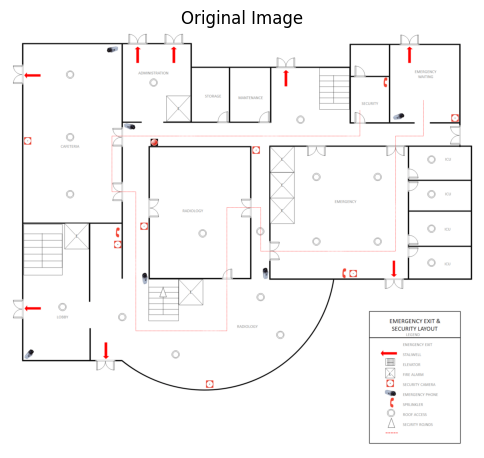

In [2]:
# Load the Image
image = cv2.imread('example6.png', cv2.IMREAD_COLOR)

utils.display_image('Original Image', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

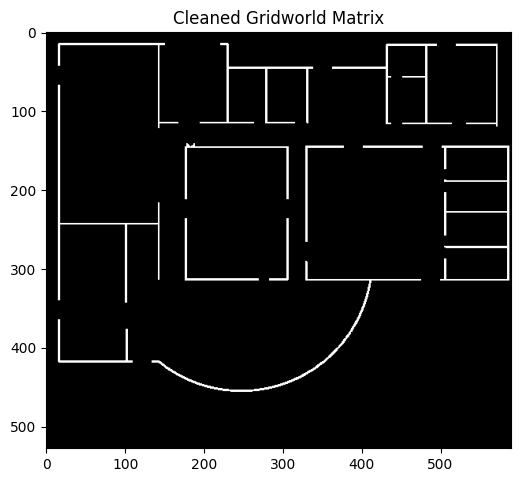

Number of rows: 528
Number of columns: 590


In [3]:
# 2d matrix representation of the above blueprint
# value of scale can be used to control how much you want to zoom into the grid world
gridworld = gridworld_converter.grid_convert('example6.png',scale = 3)
utils.display_image('Cleaned Gridworld Matrix', gridworld, cmap='gray', axis_switch = 'on')

print(f"Number of rows: {gridworld.shape[0]}\nNumber of columns: {gridworld.shape[1]}")

# Dynamic Obstacle Generator

In [4]:
# Define parameters
number_of_obstacles = 2
episode_length = 500

# Initialize the pathfinding class
pathfinder = obs.Pathfinding(gridworld)

# Generate paths for obstacles
obstacle_paths = pathfinder.generate_paths(number_of_obstacles, episode_length)

#contains a dictionary of occupied coordinate as keys at different time step as value
'only one object can occupy a coordinate at a particular time stamp'
occupied_time_steps = pathfinder.occupied_time_steps

#contains a list of start or end coordinates of each dynamic obstacle
obstacle_occupied_points = pathfinder.obstacle_occupied_points
'''
Help:
You can see the obstacle path by obstacle_paths['1'] or obstacle_paths['2']
'''

"\nHelp:\nYou can see the obstacle path by obstacle_paths['1'] or obstacle_paths['2']\n"


# EXTRA CODE:
visualisation code for only obstacles path


<IPython.core.display.Javascript object>


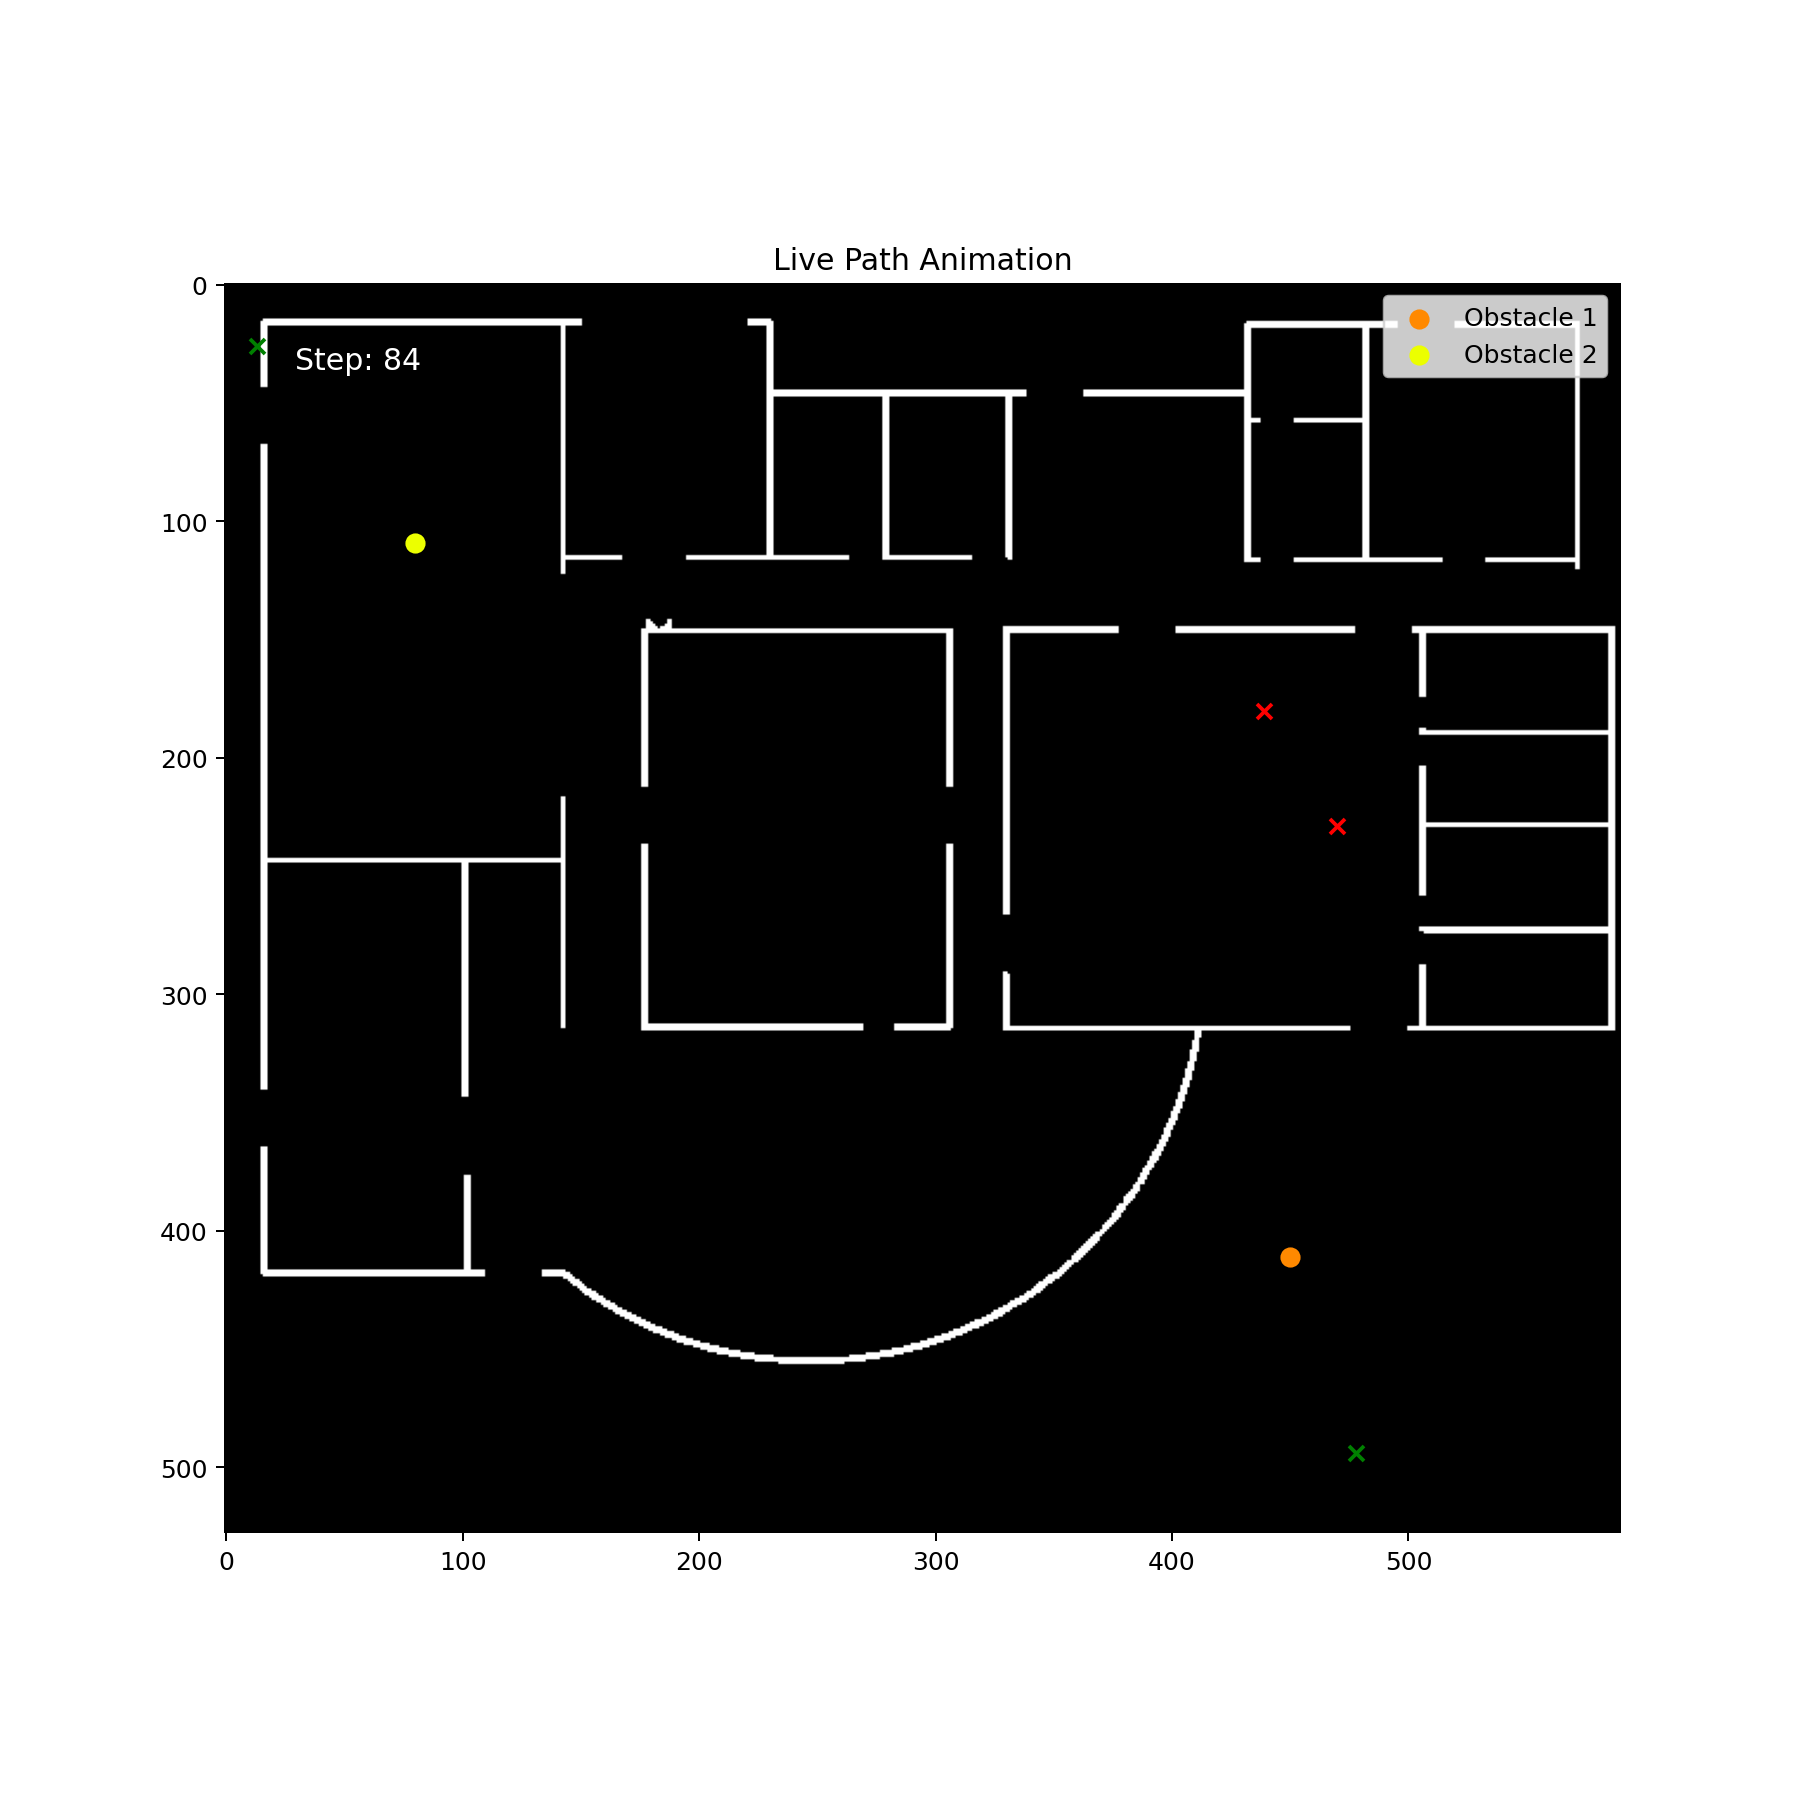

/var/folders/_w/vw1x_chj4193wcq3qzph9sl40000gn/T/ipykernel_18339/3169505345.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('hsv', num_colors + 10)


In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

# Function to generate distinct colors for the obstacles
def generate_colors(num_colors):
    colormap = cm.get_cmap('hsv', num_colors + 10)
    return [colormap(i+1) for i in range(num_colors)]

# Create a figure for the live plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gridworld, cmap='gray')

# Initialize scatter plots for the objects' current positions
scatters = []
colors = generate_colors(number_of_obstacles)  # Different colors for different obstacles

for idx, key in enumerate(obstacle_paths.keys()):
    scatter = ax.scatter([], [], color=colors[idx % len(colors)], s=50, label=f'Obstacle {key}')
    scatters.append(scatter)

# Initialize the scatter points for start and end
for key, path in obstacle_paths.items():
    start_point = path[0]
    end_point = path[-1]
    ax.scatter([start_point[1]], [start_point[0]], c='green', marker='x')
    ax.scatter([end_point[1]], [end_point[0]], c='red', marker='x')

ax.legend()

# Initialize a text annotation for the step counter
step_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='white')

# Function to update the scatter plots and step counter for each frame in the animation
def update_scatters(num, obstacle_paths, scatters):
    for idx, key in enumerate(obstacle_paths.keys()):
        path = obstacle_paths[key]
        if num < len(path):
            scatters[idx].set_offsets([path[num][1], path[num][0]])
    step_text.set_text(f'Step: {num + 1}')
    return scatters + [step_text]

# Calculate the maximum path length to set the number of frames in the animation
max_path_length = max(len(path) for path in obstacle_paths.values())

# Create the animation
ani = animation.FuncAnimation(fig, update_scatters, frames=episode_length, fargs=[obstacle_paths, scatters], interval=1, blit=True)

# Show the live plot
plt.title('Live Path Animation')
plt.show()


# Robot path finding

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

# Function to generate distinct colors for the obstacles
def generate_colors(num_colors):
    colormap = cm.get_cmap('hsv', num_colors + 10)
    return [colormap(i + 1) for i in range(num_colors)]


# Create the RL environment
env = robo.RLEnvironment(gridworld, obstacle_paths, occupied_time_steps, obstacle_occupied_points, number_of_obstacles, episode_length)

#storing the robot start position
robotPath = [env.robot_position]

# Example step through the environment
actions = [0, 1, 2, 3, 4, 5, 6, 7]  # Possible actions
action = 3
episode = 2

for i in range(episode):
    print(f"=================####################episode number: {i}")
    if i > 0:
        
        
        print("resetting environment")
        env.reset()
        robotPath = [env.robot_position]
        action = 3

    for _ in range(episode_length):

        new_position, obstacles_positions, collision, goal_reached = env.step(action)

        #random alog movement
        if collision:
            action =  np.random.choice(actions)

        print(f"Step:{env.current_step}, Position:{new_position}, Collision:{collision}, Goal Reached:{goal_reached}, Current Step:{env.current_step}, Goal coordinate:{env.goal_position}")
        print(f"        Position of Obstacles: {obstacles_positions}")
        print()
        robotPath.append(new_position)

        if goal_reached:
            print("Goal reached!")
            break
    

=================####################episode number: 0
Step:1, Position:(282, 498), Collision:False, Goal Reached:False, Current Step:1, Goal coordinate:(271, 184)
        Position of Obstacles: {'1': (322, 345), '2': (452, 508)}

Step:2, Position:(281, 498), Collision:False, Goal Reached:False, Current Step:2, Goal coordinate:(271, 184)
        Position of Obstacles: {'1': (321, 346), '2': (451, 509)}

Step:3, Position:(280, 498), Collision:False, Goal Reached:False, Current Step:3, Goal coordinate:(271, 184)
        Position of Obstacles: {'1': (320, 347), '2': (450, 510)}

Step:4, Position:(279, 498), Collision:False, Goal Reached:False, Current Step:4, Goal coordinate:(271, 184)
        Position of Obstacles: {'1': (320, 348), '2': (449, 511)}

Step:5, Position:(278, 498), Collision:False, Goal Reached:False, Current Step:5, Goal coordinate:(271, 184)
        Position of Obstacles: {'1': (320, 349), '2': (448, 512)}

Step:6, Position:(277, 498), Collision:False, Goal Reached:False,

Step:1, Position:(405, 321), Collision:False, Goal Reached:False, Current Step:1, Goal coordinate:(384, 420)
        Position of Obstacles: {'1': (250, 475), '2': (477, 403)}

Step:2, Position:(404, 321), Collision:False, Goal Reached:False, Current Step:2, Goal coordinate:(384, 420)
        Position of Obstacles: {'1': (251, 474), '2': (476, 402)}

Step:3, Position:(403, 321), Collision:False, Goal Reached:False, Current Step:3, Goal coordinate:(384, 420)
        Position of Obstacles: {'1': (252, 473), '2': (475, 401)}

Step:4, Position:(402, 321), Collision:False, Goal Reached:False, Current Step:4, Goal coordinate:(384, 420)
        Position of Obstacles: {'1': (253, 472), '2': (474, 400)}

Step:5, Position:(401, 321), Collision:False, Goal Reached:False, Current Step:5, Goal coordinate:(384, 420)
        Position of Obstacles: {'1': (254, 471), '2': (473, 399)}

Step:6, Position:(400, 321), Collision:False, Goal Reached:False, Current Step:6, Goal coordinate:(384, 420)
        Pos

In [12]:
len(robotPath)

501

# Code for live visualisation:

Visualization with the robot and dynamic obstacles.


<IPython.core.display.Javascript object>


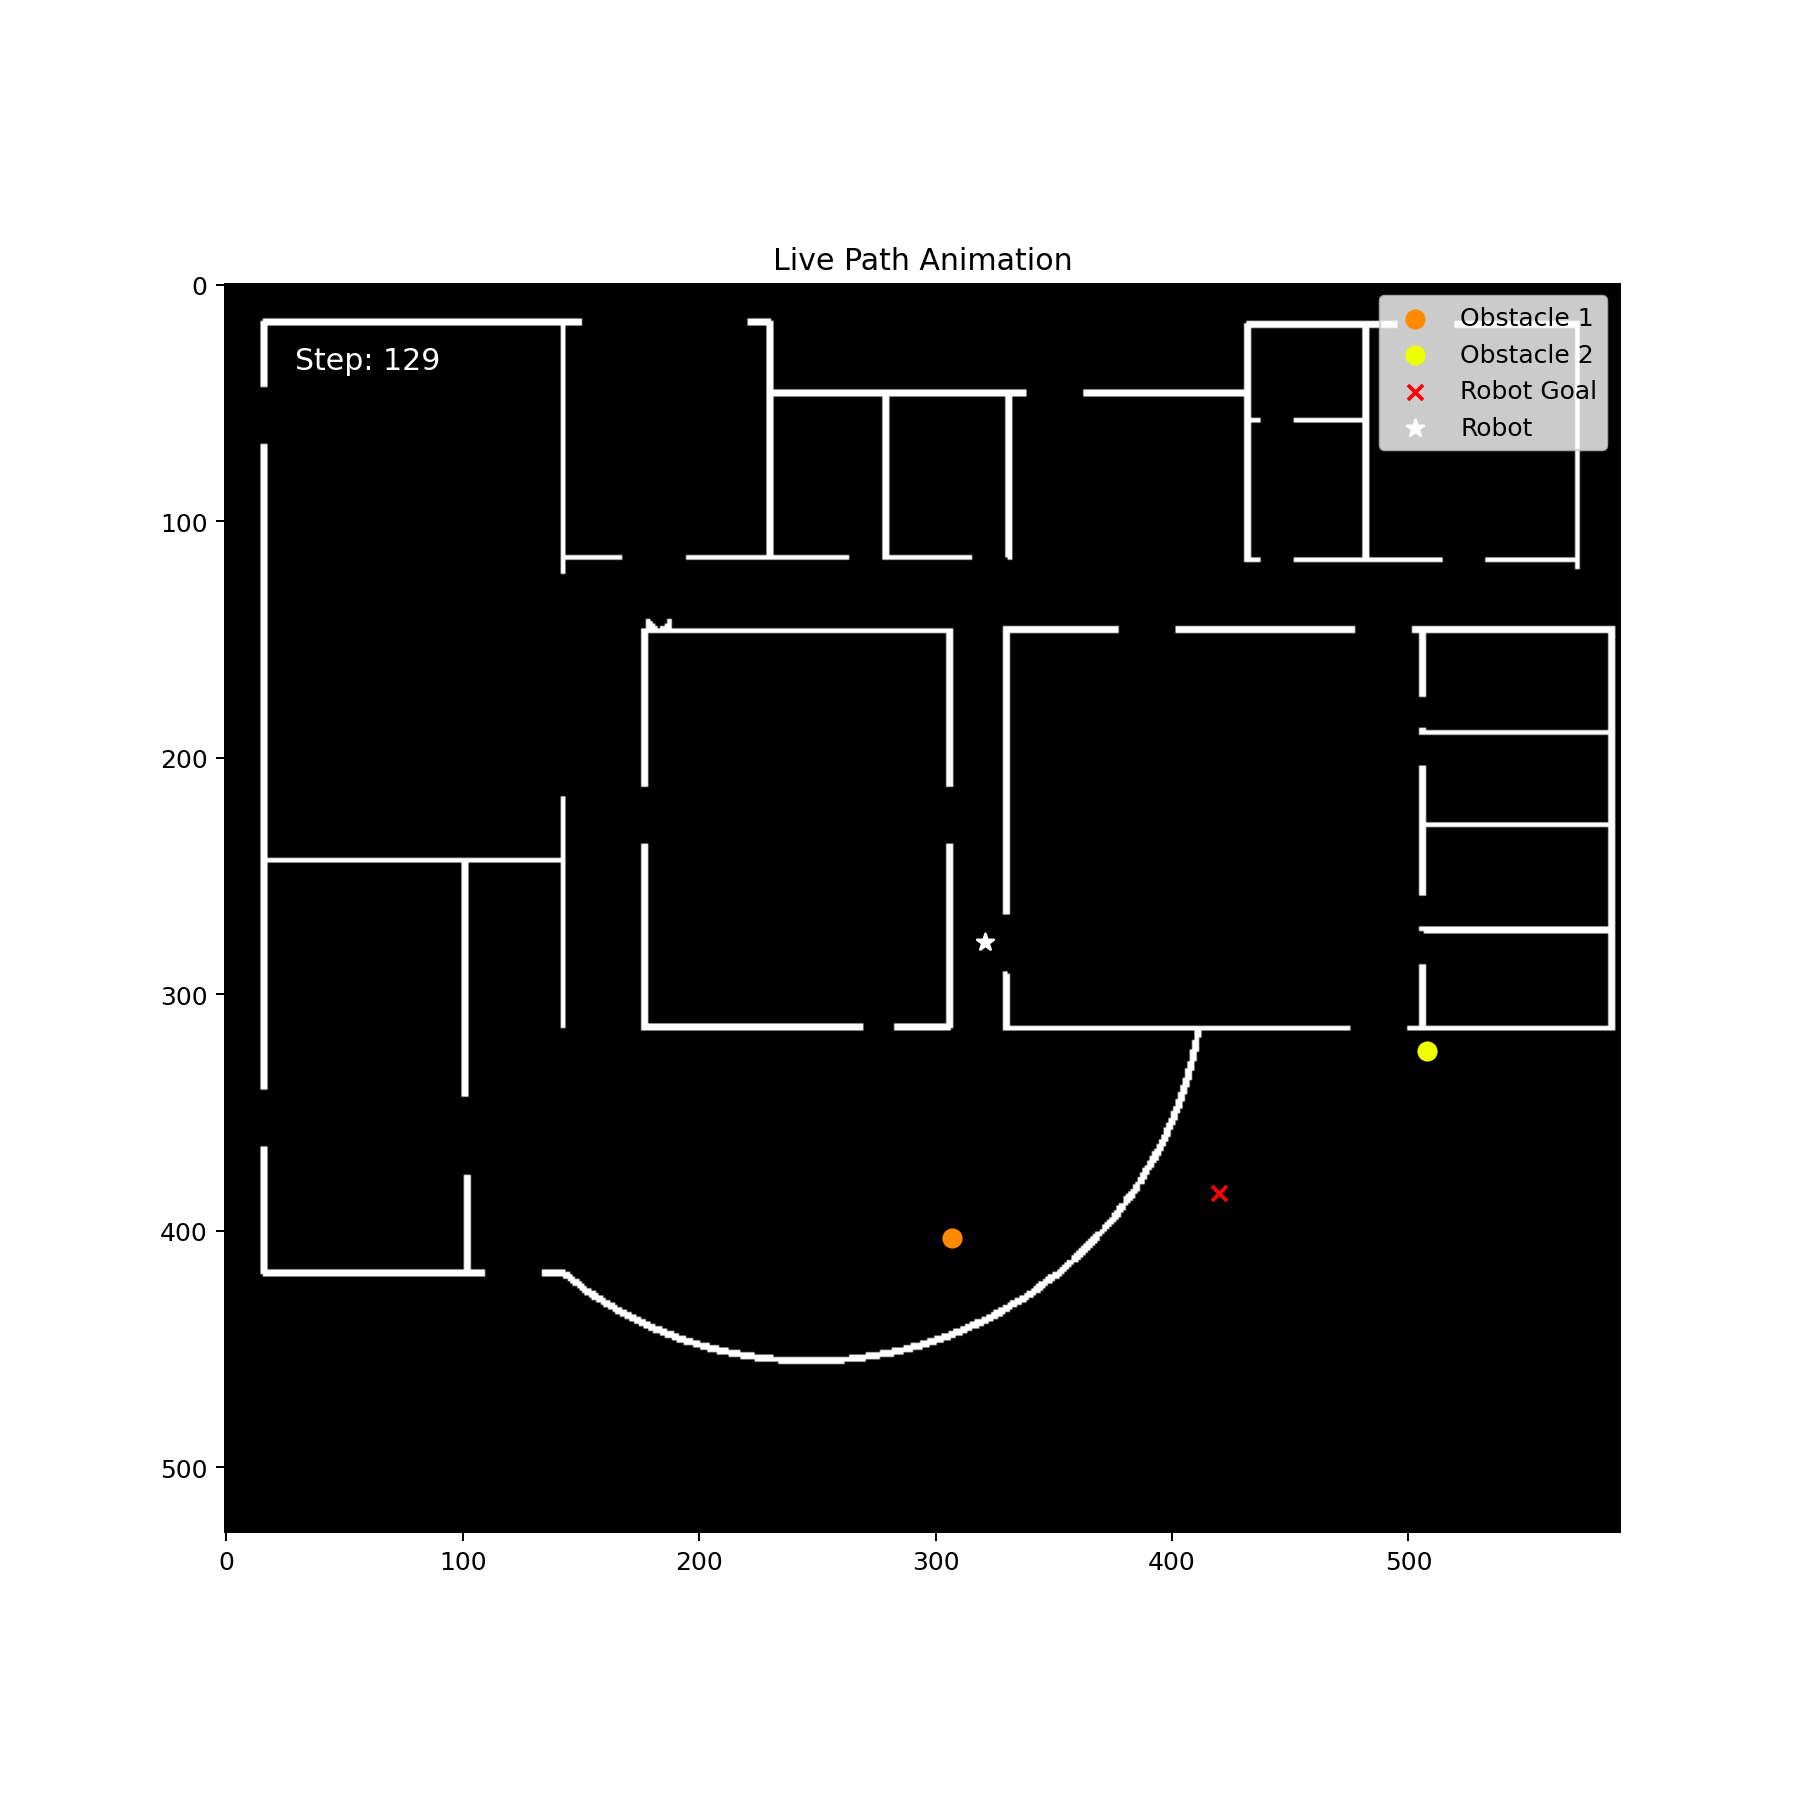

/var/folders/_w/vw1x_chj4193wcq3qzph9sl40000gn/T/ipykernel_18722/1993421187.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('hsv', num_colors + 10)


In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

# Assuming gridworld, obstacle_paths, number_of_obstacles, episode_length, and robotPath are already defined

# Function to generate distinct colors for the obstacles
def generate_colors(num_colors):
    colormap = cm.get_cmap('hsv', num_colors + 10)
    return [colormap(i + 1) for i in range(num_colors)]

# Create a figure for the live plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gridworld, cmap='gray')

# Initialize scatter plots for the objects' current positions
scatters = []
colors = generate_colors(number_of_obstacles)  # Different colors for different obstacles

for idx, key in enumerate(obstacle_paths.keys()):
    scatter = ax.scatter([], [], color=colors[idx % len(colors)], s=50, label=f'Obstacle {key}')
    scatters.append(scatter)

# Initialize the scatter points for the robot's start and goal positions
robot_start = robotPath[0]
robot_goal = env.goal_position
# ax.scatter([robot_start[1]], [robot_start[0]], c='green', marker='^', label='Robot Start')
ax.scatter([robot_goal[1]], [robot_goal[0]], c='red', marker='x', label='Robot Goal')

# Initialize the scatter points for start and end of obstacles
for key, path in obstacle_paths.items():
    start_point = path[0]
    end_point = path[-1]
#     ax.scatter([start_point[1]], [start_point[0]], c='green', marker='x')
#     ax.scatter([end_point[1]], [end_point[0]], c='red', marker='x')

# Initialize a scatter plot for the robot's current position
robot_scatter = ax.scatter([], [], color='white', s=50, marker='*', label='Robot')
scatters.append(robot_scatter)

ax.legend()

# Initialize a text annotation for the step counter
step_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='white')

# Function to update the scatter plots and step counter for each frame in the animation
def update_scatters(num, obstacle_paths, scatters, robot_path):
    for idx, key in enumerate(obstacle_paths.keys()):
        path = obstacle_paths[key]
        if num < len(path):
            scatters[idx].set_offsets([path[num][1], path[num][0]])
    
    if num < len(robot_path):
        scatters[-1].set_offsets([robot_path[num][1], robot_path[num][0]])
    
    step_text.set_text(f'Step: {num + 1}')
    return scatters + [step_text]

# Calculate the maximum path length to set the number of frames in the animation
max_path_length = max(len(path) for path in obstacle_paths.values())
max_path_length = max(max_path_length, len(robotPath))

# Create the animation
ani = animation.FuncAnimation(fig, update_scatters, frames=max_path_length, fargs=[obstacle_paths, scatters, robotPath], interval=1, blit=True)

# Show the live plot
plt.title('Live Path Animation')
plt.show()